In [1]:
import collections
import math
import os

from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import sklearn

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sklearn.__version__

'0.17.1'

# Load MNIST data using a script in tensorflow
- [MNIST loader in tensorflow](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py)

In [3]:
mnist = input_data.read_data_sets('mnist', one_hot=False)
display(mnist.train.images.shape)
display(mnist.validation.images.shape)
display(mnist.train.images.shape)

def print_accuracy(clf, label):
    if label == 'train':
        dataset = mnist.train
    elif label == 'validation':
        dataset = mnist.validation
    elif label == 'test':
        dataset = mnist.test
    else:
        raise Exception('Unknown label: %s' % label)
    print '%s accuracy: %.3f%%' % (
        label,
        100. * np.count_nonzero(clf.predict(dataset.images) == dataset.labels) / dataset.images.shape[0])

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


(55000, 784)

(5000, 784)

(55000, 784)

# Linear Logistic Regression
- [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Examples: Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve

clf = LogisticRegression()
clf.fit(mnist.train.images, mnist.train.labels)
None

In [5]:
print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 92.807%
validation accuracy: 92.100%
test accuracy: 91.970%


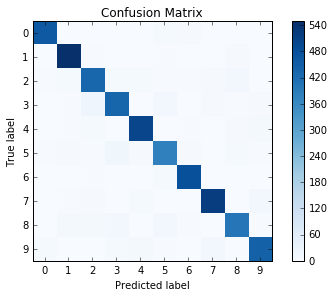

In [6]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(mnist.validation.labels, clf.predict(mnist.validation.images))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

target_names = np.arange(10)
tick_marks = target_names
plt.xticks(tick_marks, target_names, rotation=0)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Decision Trees
- [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(mnist.train.images, mnist.train.labels)

print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 90.236%
validation accuracy: 86.180%
test accuracy: 86.640%


## BAGGING
- [sklearn.ensemble.BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- base_estimator is cloned inside BaggingClassifier (See [BaseEnsemble._make_estimator](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/base.py)).

In [8]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=10)
clf.fit(mnist.train.images, mnist.train.labels)

print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 95.744%
validation accuracy: 93.260%
test accuracy: 92.660%


## Random Forests
- [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- Random Forrests training is fast, easy to parallelize (n_jobs) yet the prediction performance is good. It's much faster than the original decision tree classifier.

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=10, max_depth=15)
clf.fit(mnist.train.images, mnist.train.labels)
None

In [10]:
print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 99.724%
validation accuracy: 97.040%
test accuracy: 96.500%
